# Intrusion Detection Project

In [1]:
# Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Additional library to properly play videos on jupyter notebook
from IPython.display import clear_output

In [2]:
def manhattan(current, previous):
    """Computes manhattan or L1 distance between two frames"""
    diff = np.abs(current - previous)
    # if rgb compute summation over channels
    if len(current.shape) == 3 and current.shape[-1] == 3:
        diff = np.sum(diff, axis = -1)
    return diff

def euclidean(current, previous):
    """Computes euclidean or L2 distance between two frames"""
    diff = np.abs(current - previous)**2
    # if rgb compute summation over channels
    if len(current.shape) == 3 and current.shape[-1] == 3:
        diff = np.sum(diff, axis = -1)
    return np.sqrt(diff)

def maximum(current, previous):
    """Computes maximum or L-infinite distance between two frames"""
    diff = np.abs(current - previous)
    if len(current.shape) == 3 and current.shape[-1] == 3:
        diff = np.max(diff, axis = -1)
    return diff

In [3]:
# Parameters
path = 'rilevamento-intrusioni-video.avi'

distance = euclidean
# Two frame difference threshold
th = 30
# Background initialization threshold
bg_th = 350

## Background Initialization

### Blind

In [4]:
def comparison_init_bg(path, n):
    cap = cv2.VideoCapture(path)
    if cap.isOpened():
        idx = 0
        backgrounds = []
        try:
            while(idx < n):
                # Capture the frame
                ret, frame = cap.read()

                if not ret or frame is None:
                    # Release the video if ret is false
                    cap.release()
                    print("Released Video Resource")
                    # Break exit for the loops
                    break

                frame = frame.astype(np.float)
                backgrounds.append(frame)
                idx += 1

            # Compute backgrounds
            bg = np.stack(backgrounds, axis=0)
            plt.figure(figsize=(10, 5))
            
            # Background computed with median interpolation
            median_bg = np.median(bg, axis=0)
            median_bg = median_bg.astype(np.uint8)
            plt.subplot(1,2,1)
            plt.axis('off')
            plt.title("Background (median, " + str(n) + " frames)")
            plt.imshow(cv2.cvtColor(median_bg, cv2.COLOR_BGR2RGB))
            #cv2.imwrite('bg_median_' + str(n) + '.jpg',  median_bg)
            
            #Background computed with mean interpolation
            mean_bg = np.mean(bg, axis=0)
            mean_bg = mean_bg.astype(np.uint8)
            plt.subplot(1,2,2)
            plt.axis('off')
            plt.title("Background (mean, " + str(n) + " frames)")
            plt.imshow(cv2.cvtColor(mean_bg, cv2.COLOR_BGR2RGB))
            #cv2.imwrite('bg_mean_' + str(n) + '.jpg',  mean_bg)

            plt.show()
        except KeyboardInterrupt:
            # If we press stop (jupyter GUI) release the video
            cap.release()
            print("Released Video Resource")

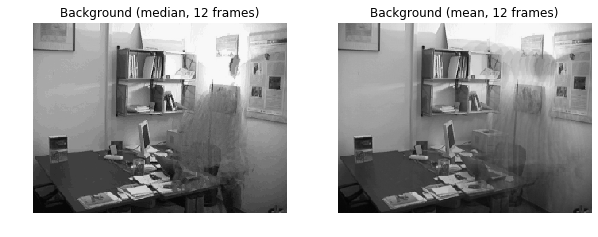

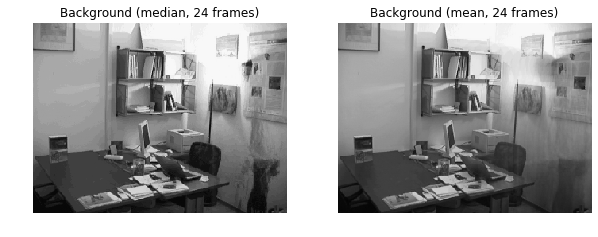

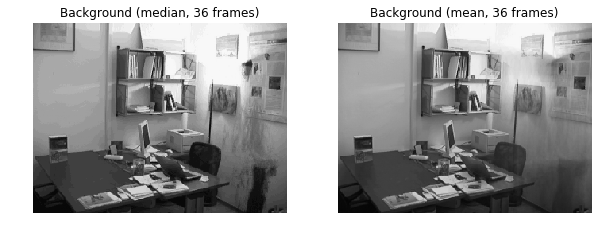

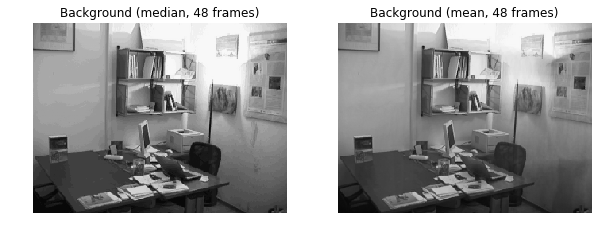

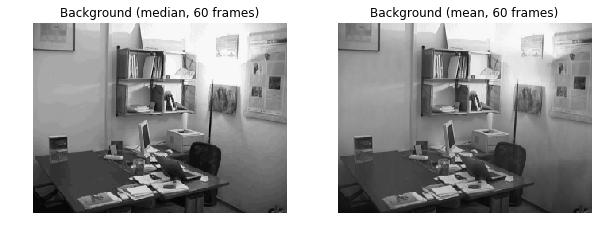

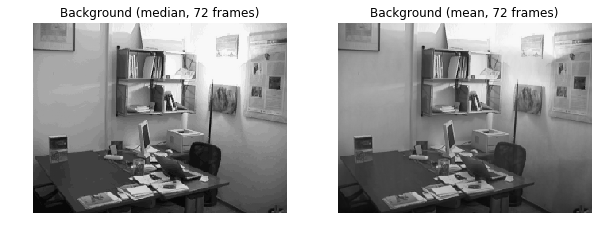

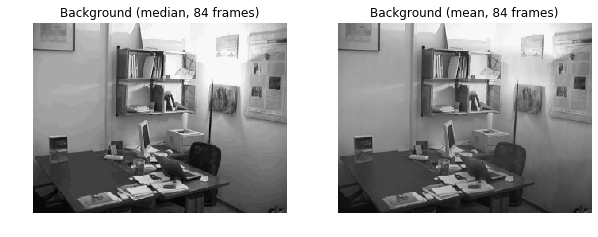

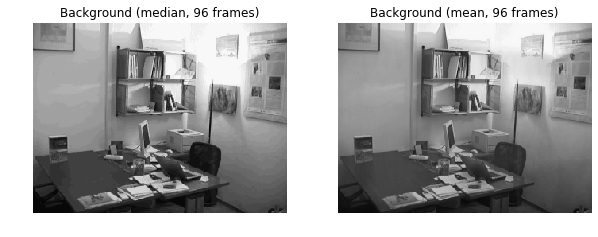

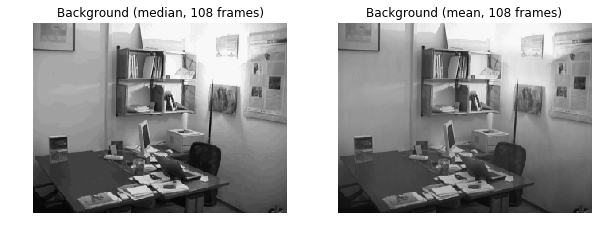

In [5]:
# Comparing results of Blind background initialization
# considering the first 9 seconds of the video
freq = 12
for i in range(freq, freq*10, freq):
    comparison_init_bg(path, i)

### Selective

In [6]:
# Two frame difference + morpholical operators
def tfd_morph(current, previous, distance, th):
    """Computes Two frame difference algorithm and applies a sequence 
        of morphological operators to be conservative. 
        Used for Selective background initialization"""
    diff = distance(current, previous)

    mask = diff > th
    mask = mask.astype(np.uint8)*255

    kernel_o = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    o_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_o)

    d_mask = cv2.dilate(o_mask,kernel_o,iterations = 15)
    
    kernel_c = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    c_mask = cv2.morphologyEx(d_mask, cv2.MORPH_CLOSE, kernel_c)

    return c_mask

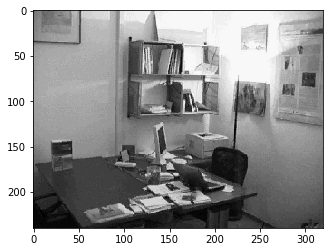

frames used: 22


In [7]:
cap = cv2.VideoCapture(path)
if cap.isOpened():
    idx = 0
    count = bg_th + 1
    try:
        while (count > bg_th):
            # Capture the frame
            ret, frame = cap.read()

            if not ret or frame is None:
                # Release the video if ret is false
                cap.release()
                print("Released Video Resource")
                # Break exit for the loops
                break

            frame = frame.astype(np.float32)

            if idx == 0:
                # Inizialization with first frame
                bg = frame.copy()
                #init_mask = np.zeros_like(frame)

            else: 
                mask = tfd_morph(frame, previous, distance, th)

                if idx == 1:
                    init_mask = mask.copy()
                else:
                    # Background selective initialization
                    change = np.logical_and(init_mask == 255, mask == 0)
                    bg[change] = frame[change]
                    init_mask[change] = 0
                count = np.sum(init_mask == 255)
            previous = frame
            idx += 1

        if count > 0:
            unitialized = init_mask == 255
            bg[unitialized] = frame[unitialized]
            
        plt.imshow(cv2.cvtColor(bg.astype(np.uint8), cv2.COLOR_BGR2RGB))
        plt.show()
        init_frames = idx
        print("frames used: {}".format(idx+1))
        # cv2.imwrite("bg.jpg", bg.astype(np.uint8))
        
    except KeyboardInterrupt:
        # If we press stop (jupyter GUI) release the video
        cap.release()
        print("Released Video Resource")

## Change Detection

In [8]:
def bg_difference(current, bg, idx, distance, th):
    """Two frame background difference + morphological operators 
        used to improve the change detection."""
    diff = distance(current, bg)

    mask = diff > th
    mask = mask.astype(np.uint8)*255
    
    kernel_o = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    o_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_o)
        
    kernel_c = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21,21))
    c_mask = cv2.morphologyEx(o_mask, cv2.MORPH_CLOSE, kernel_c)
    
    kernel_o1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    o1_mask = cv2.morphologyEx(c_mask, cv2.MORPH_OPEN, kernel_o1)

    return o1_mask

In [9]:
def pseudo_colors(img, sat_val=255, bright_val=255):
    """Given a labeled gray-scale image, 
        computes the pseudo colors and returns the bgr image"""
    # Map labels to hsv colorspace. Hue channel range is 0-179 in OpenCV
    hue_max = 179
    # Build hue, saturation, brightness channels separately
    max_label = np.max(img)
    if max_label > 0:
        hue_ch = np.uint8(hue_max * img / max_label)
    else:
        hue_ch = np.zeros_like(img)
        
    sat_ch = np.ones_like(img)*sat_val
    bright_ch = np.ones_like(img)*bright_val
    # Stack them
    hsv_img = np.stack([hue_ch, sat_ch, bright_ch], axis=-1)
    # To keep the background black
    hsv_img[hue_ch == 0] = 0
    # Convert to BGR image
    bgr_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
    
    return bgr_img

In [10]:
def show_graphical_output(ccmask, frame):
    """Displays both the frame and the correspondent mask 
        of labeled blobs corresponding to detected objects"""
    ccmask = ccmask.astype(np.uint8)
    pseudo_color_mask = pseudo_colors(ccmask)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2RGB))

    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(pseudo_color_mask, cv2.COLOR_BGR2RGB))
    
    plt.show()
    return pseudo_color_mask

In [11]:
def show_labeled_contours(mask, frame):
    """Displays the labeled contours corresponding to detected objects"""
    _, contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cont_mask = np.zeros_like(mask)
    cv2.drawContours(cont_mask, contours, -1, 255, 2)  
    
    num_labels, ccmask = cv2.connectedComponents(cont_mask)
    ccmask = ccmask.astype(np.uint8)
    pseudo_color_mask = pseudo_colors(ccmask)
    
    frame = frame.astype(np.uint8)
    frame[pseudo_color_mask > 0] = pseudo_color_mask[pseudo_color_mask > 0]
    
    plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    
    plt.show()
    return frame

In [12]:
def classify(features):
    """Classification function to distinguish detected objects into categories"""
    types = ['other', 'person']
    return types[features['compactness'] > 20]

In [13]:
def isTrueObj(roi_contour, roi_canny, contour_lenght):
    """Distinguishes True and False detected objects
        comparing detected contours and 'True' contours computed by Canny"""
    false_th = 0.2
    real_contour = np.logical_and(roi_contour > 0, roi_canny > 0)
    return (np.sum(real_contour) / contour_lenght) > false_th

In [14]:
def compute_features(num_labels, ccmask, stats, centroids, canny_edges):
    """Computes a set of features for each connected component, 
        including the classification of the objects and of the contours"""
    res = []
    for i in range(1, num_labels):
        features_i = {}
        
        roi_i = ccmask[stats[i, 1]: stats[i, 1] + stats[i, 3], stats[i, 0]: stats[i, 0] + stats[i, 2]]
        roi_i = (roi_i == i).astype(np.uint8)
        _, contours, hierarchy = cv2.findContours(roi_i, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        c = contours[0]
        perimeter = cv2.arcLength(c, True)
        # Already computed area (stats[i, -1]) but it doesn't take into account holes. 
        area = cv2.contourArea(c)
        compactness = (perimeter**2)/area
        
        features_i['label'] = i
        features_i['centroid_x'] = centroids[i][0]
        features_i['centroid_y'] = centroids[i][1]
        features_i['perimeter'] = perimeter
        features_i['area'] = area
        features_i['compactness'] = compactness
        
        features_i['type'] = classify(features_i)
        roi_i_canny = canny_edges[stats[i, 1]: stats[i, 1] + stats[i, 3], stats[i, 0]: stats[i, 0] + stats[i, 2]]
        features_i['isTrue'] = isTrueObj(cv2.drawContours(np.zeros_like(roi_i), contours, -1, 255, 1), roi_i_canny, perimeter)
        
        
                
        res.append(features_i)
    return res

In [15]:
def text_output(csv_file, idx, num_labels, features):
    """Writes to a csv file the requested report"""
    csv_file.write("{},{}\n".format(idx, num_labels-1))
    for el in features:
        csv_file.write("{},{},{},{:.2f},{},{},{},{}\n".format(
                      el['label'],
                      round(el['area']),
                      round(el['perimeter']),
                      el['compactness'],
                      int(round(el['centroid_x'])),
                      int(round(el['centroid_y'])),
                      el['type'],
                      el['isTrue']))

In [16]:
# Parameters
path = 'rilevamento-intrusioni-video.avi'

distance = euclidean
th = 30
bg_th = 350

# Adaptation rate (speed of adaptation of the background
# model to changes occurring in the monitored scene)
alpha = 0.25

# Text output file name
text_file = 'output_text.csv'

# Graphical output file name
graph_file = 'output_video.avi'

In [17]:
csv_file = open(text_file, "w")
cap = cv2.VideoCapture(path)

# Getting original video params
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
# N.B. we need to specify the correct width and height of the frames otherwise we will not be able to reproduce the video
out = cv2.VideoWriter(graph_file, fourcc, fps, (w,  h))

if cap.isOpened():
    idx = 0
    bg_new = bg.copy()
    try:
        while(True):
            # Capture the frame
            ret, frame = cap.read()

            if not ret or frame is None:
                # Release the video if ret is false
                cap.release()
                print("Released Video Resource")
                # Break exit for the loops
                break
                
            frame = frame.astype(np.float32)

            if idx > init_frames:
                # Compute change mask
                mask = bg_difference(frame, bg_new, idx, distance, th)
                
                # Find 'real' edges
                gray = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2GRAY)
                c_edges = cv2.Canny(gray, 100, 200)                
                
                # Graphical output
                num_labels, ccmask, stats, centroids = cv2.connectedComponentsWithStats(mask)
                color_mask = show_graphical_output(ccmask, frame)
                # color_mask = show_labeled_contours(mask, frame)
                
                # Text Output
                features = compute_features(num_labels, ccmask, stats, centroids, c_edges)
                text_output(csv_file, idx, num_labels, features)
                
                # Background selective updating
                kernel_3 = np.ones((3,3),np.uint8)
                dial_mask = cv2.dilate(mask,kernel_3,iterations = 3)
                change = dial_mask == 0
                if np.sum(change) > 0:
                    bg_new[change] = alpha * frame[change] + (1 - alpha) * bg_new[change]

                out.write(color_mask)

            idx += 1
            # Clear cell output when new frame is available
            clear_output(wait=True)
    except KeyboardInterrupt:
        # If we press stop (jupyter GUI) release the video
        cap.release()
        print("Released Video Resource")

# Release everything if job is finished
out.release()    
csv_file.close()

Released Video Resource
